## ENSEMBLE LEARNING (LR + XGB)
LOGISTIC REGRESSION (BASE LEARNER)
XGBOOST (META LEARNEER)

### Load Pre-Trained Models and Vectorizers

In [1]:
import pickle
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import pandas as pd

# Load the Logistic Regression model and vectorizer
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

# Load the XGBoost model, label encoder, and TF-IDF vectorizer
with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:24:59] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in P

### Prepare the Dataset for Testing

In [2]:
# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' column exists
if 'cleaned_text' not in data.columns:
    raise ValueError("The dataset must have a 'cleaned_text' column.")

# Remove rows with missing values in 'cleaned_text'
data.dropna(subset=['cleaned_text'], inplace=True)

# Split features and target
X_test = data['cleaned_text']
y_test = data['mental_health_issue']

# Encode target labels
y_test = label_encoder.transform(y_test)

# Transform the text using the respective vectorizers
X_test_lr = lr_vectorizer.transform(X_test)  # Logistic Regression vectorizer
X_test_xgb = tfidf_vectorizer.transform(X_test)  # XGBoost vectorizer


### Stack Predictions for Ensemble

In [3]:
import numpy as np

# Get predictions from the base models
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)

# Combine predictions as new features
stacked_features = np.hstack((lr_predictions_proba, xgb_predictions_proba))


In [4]:
print(type(lr_model))
print(type(xgb_model))


<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'xgboost.sklearn.XGBClassifier'>


### Train a Meta-Learner

In [5]:
# Train meta-learner using combined features (optional step if not pre-trained)
# Split data into training and test sets
from sklearn.model_selection import train_test_split, cross_val_score
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    stacked_features, y_test, test_size=0.2, random_state=42, stratify=y_test
) # Example using test data as meta-training data

meta_learner = LogisticRegression(max_iter=5000)
meta_learner.fit(X_train1, y_train1)

# Save the trained meta-learner
with open('meta_learner.pkl', 'wb') as file:
    pickle.dump(meta_learner, file)


### Make Predictions

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

# Load the pre-trained meta-learner
with open('meta_learner.pkl', 'rb') as file:
    meta_learner = pickle.load(file)

# Predict using the meta-learner
final_predictions = meta_learner.predict(X_test1)

# Evaluate the Logistic Regression meta-learner
test_accuracy_lr = accuracy_score(y_test1, final_predictions)
report_lr = classification_report(y_test1, final_predictions, target_names=label_encoder.classes_)

print(f"Logistic Regression Meta-Learner Test Accuracy: {test_accuracy_lr * 100:.2f}%")
print("Classification Report (Test Set):\n", report_lr)
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test1, final_predictions))


# Calculate the mean and standard deviation of validation accuracies
# Use X_train and y_train, which are subsets of stacked_features and have the same size
cross_val_accuracies = cross_val_score(
    meta_learner, stacked_features, y_test, cv=5, scoring='accuracy' # Changed stacked_features and y_test to X_train and y_train
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

Logistic Regression Meta-Learner Test Accuracy: 96.31%
Classification Report (Test Set):
               precision    recall  f1-score   support

     anxiety       0.97      0.94      0.95       400
     bipolar       0.92      0.85      0.88       388
  depression       0.95      0.94      0.94       392
      normal       0.97      0.99      0.98      2136
        ptsd       0.97      0.96      0.96       397

    accuracy                           0.96      3713
   macro avg       0.96      0.93      0.95      3713
weighted avg       0.96      0.96      0.96      3713

Confusion Matrix (Test Set):
 [[ 376    4    7   10    3]
 [   1  328    5   50    4]
 [   9   10  367    2    4]
 [   0   10    0 2125    1]
 [   3    3    6    5  380]]
Cross-Validation Accuracies: [0.97118233 0.96956639 0.96579585 0.94021007 0.94990574]
Mean Validation Accuracy: 95.93%
Validation Accuracy Std Dev: 1.22%


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform stratified cross-validation and compute accuracies
cross_val_accuracies = []
for train_index, test_index in skf.split(stacked_features, y_test):
    X_train_fold, X_test_fold = stacked_features[train_index], stacked_features[test_index]
    y_train_fold, y_test_fold = y_test[train_index], y_test[test_index]

    meta_learner.fit(X_train_fold, y_train_fold)
    fold_accuracy = meta_learner.score(X_test_fold, y_test_fold)
    cross_val_accuracies.append(fold_accuracy)

# Convert to NumPy array for consistency
cross_val_accuracies = np.array(cross_val_accuracies)

# Calculate mean and standard deviation
mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

Cross-Validation Accuracies: [0.96364126 0.95744681 0.96175599 0.95933208 0.96202532]
Mean Validation Accuracy: 96.08%
Validation Accuracy Std Dev: 0.22%


### Confusion Matrix

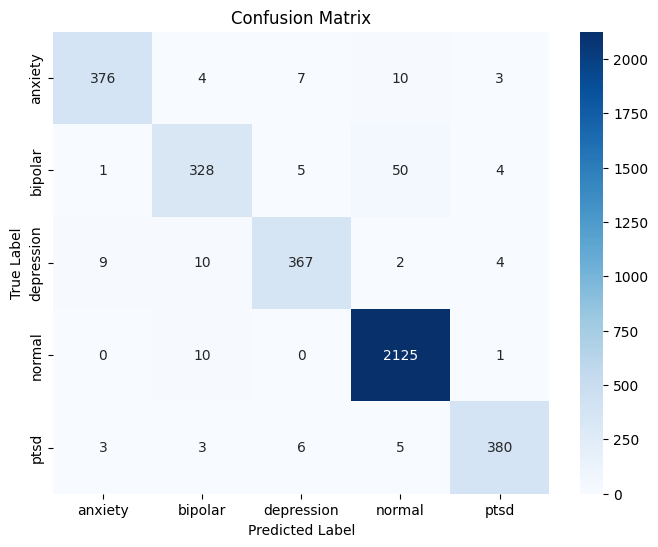

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test1, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


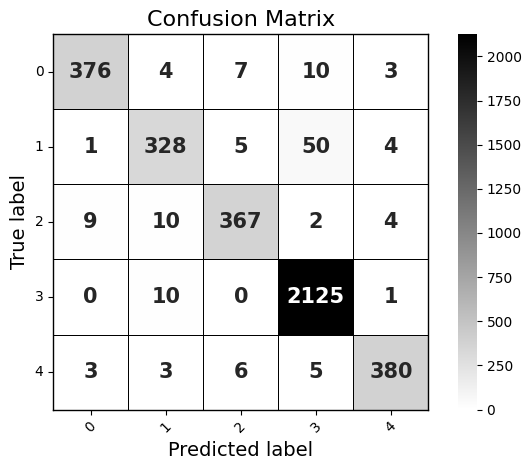

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test1, final_predictions)

ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='gist_yarg',         # grayscale colormap with deep tones ( gist_yarg )
    cbar=True,                # color bar for value reference
    cbar_kws={'label': ''},
    annot_kws={'size':15, 'weight':'bold'},
    linewidths=0.5,           # thinner borders
    linecolor='black',
    square=True
)

# Fix bottom and right border visibility
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### ROC AUC Curve

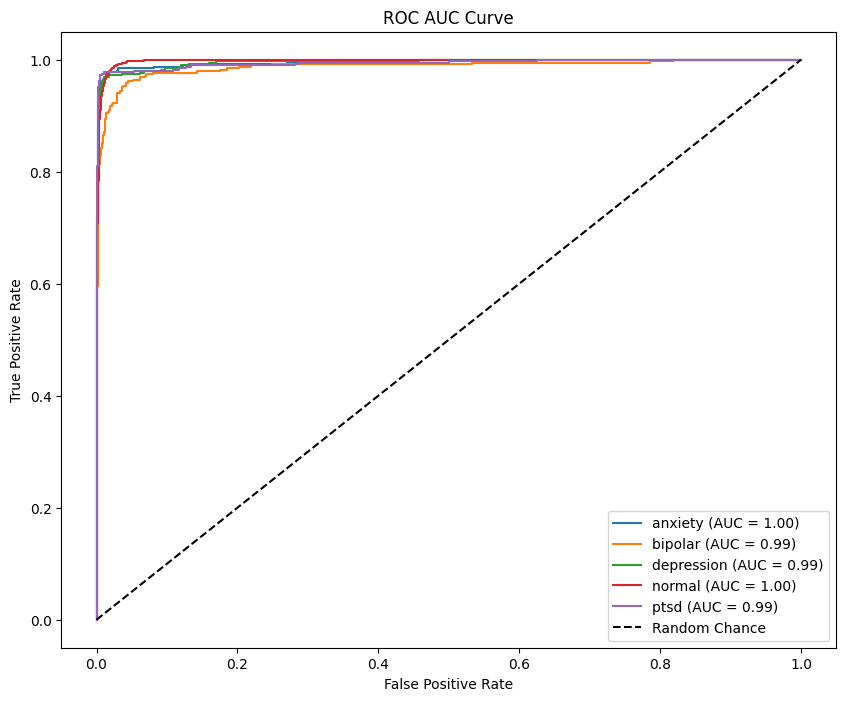

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output (one-vs-rest)
y_test_bin = label_binarize(y_test1, classes=range(len(label_encoder.classes_)))

# Calculate probabilities for the test set only
final_predictions_proba = meta_learner.predict_proba(X_test1) # Changed stacked_features to X_test

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()

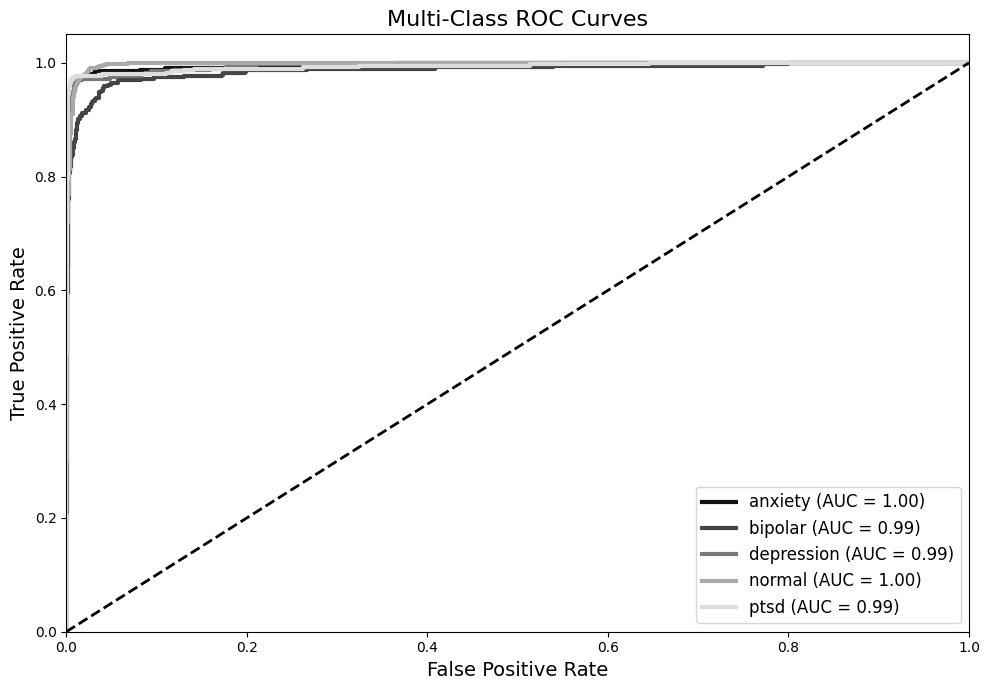

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

greys = ['#111111', '#444444', '#777777', '#AAAAAA', '#DDDDDD']

# Binarize the output (one-vs-rest)
y_test_bin = label_binarize(y_test1, classes=range(len(label_encoder.classes_)))

# Calculate probabilities for the test set only
final_predictions_proba = meta_learner.predict_proba(X_test1) # Changed stacked_features to X_test

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 7))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    color = greys[i % len(greys)]
    plt.plot(fpr, tpr, color=color, lw=3, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-Class ROC Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()
